<a href="https://colab.research.google.com/github/reireu/dspro/blob/main/%E8%AA%B2%E9%A1%8C%E3%82%B3%E3%83%94%E3%83%9A%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy scikit-learn xgboost shap openpyxl matplotlib seaborn


# Task
Analyze rice production data from the "df_rice_BD.xlsx" file. The task involves building and evaluating an XGBoost regression model, and then interpreting its predictions using SHAP analysis. The 'Y' column represents the rice production, which is the target variable, and the 'Time' column should be treated as a feature. The analysis will include data preprocessing, model training, performance evaluation using R2 Score and RMSE, SHAP value calculation, and visualization of feature importance. Finally, the SHAP feature importance will be exported to an Excel file named "shap_importance_rice.xlsx".

## Verify Data Structure and Correct Target

### Subtask:
Modify the code to correctly identify 'Y' as the target variable and 'Time' as a feature, while handling or dropping metadata columns from the DataFrame.


**Reasoning**:
The current `df` loaded from `df_rice_BD.xlsx` appears to be a metadata table, not the actual dataset required for modeling. It contains `Variable` and `description` columns, with `Time` and `Y` as values within the `Variable` column. To correctly proceed with the task of identifying 'Y' as the target and 'Time' as a feature, the actual dataset needs to be loaded. Without further information on the structure of `df_rice_BD.xlsx`, I will assume the actual data with `Time` and `Y` as columns is present in the file but needs to be loaded by skipping the initial metadata rows. I'll make a plausible assumption to skip the first two rows, as they resemble the provided `df.head()` output which describes the variables. Then, I will apply the requested preprocessing steps to define `X` and `y`.



**Reasoning**:
The previous attempt to load the data with `skiprows` resulted in an empty DataFrame, causing the `ValueError: With n_samples=0`. This indicates that the file structure is not as initially assumed, and the original `df.head()` output (showing `Variable` and `description` columns) suggests the default `pd.read_excel` loads a metadata sheet. To correctly identify 'Y' as the target and 'Time' as a feature, I will iterate through all sheets in the Excel file to find the one that contains these columns, assuming the actual data resides in a different sheet.



In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import xgboost as xgb
import shap

import matplotlib.pyplot as plt


In [12]:
excel = pd.ExcelFile("/content/df_rice_BD.xlsx")

df = None
for sheet in excel.sheet_names:
    tmp = pd.read_excel(excel, sheet_name=sheet)
    if {"Time", "Y"}.issubset(tmp.columns) and len(tmp) > 10:
        df = tmp.copy()
        print(f"✔ Data found in sheet: {sheet}")
        break

if df is None:
    raise ValueError("Time と Y を含む実データシートが見つかりません")

df = df.sort_values("Time").reset_index(drop=True)

print(df.head())
print(df.shape)


✔ Data found in sheet: Data
   Time         Y
0  1961  14426184
1  1962  13304520
2  1963  15934944
3  1964  15753588
4  1965  15750540
(60, 2)


In [13]:
df["Y_lag1"] = df["Y"].shift(1)
df["Y_lag2"] = df["Y"].shift(2)
df["Y_lag3"] = df["Y"].shift(3)

df["growth_rate"] = df["Y"].pct_change()

# lag による欠損行を削除
df = df.dropna().reset_index(drop=True)

print(df.head())
print(df.shape)


   Time         Y      Y_lag1      Y_lag2      Y_lag3  growth_rate
0  1964  15753588  15934944.0  13304520.0  14426184.0    -0.011381
1  1965  15750540  15753588.0  15934944.0  13304520.0    -0.000193
2  1966  14363000  15750540.0  15753588.0  15934944.0    -0.088095
3  1967  16757000  14363000.0  15750540.0  15753588.0     0.166678
4  1968  17015504  16757000.0  14363000.0  15750540.0     0.015427
(57, 6)


In [14]:
X = df.drop(columns=["Y"])
y = df["Y"]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (57, 5)
y shape: (57,)


In [15]:
seeds = [0, 1, 2, 3, 4]

shap_results = []
performance = []


In [16]:
for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )

    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=seed
    )

    model.fit(X_train, y_train)

    # 予測
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    performance.append({
        "seed": seed,
        "R2": r2,
        "RMSE": rmse
    })

    # SHAP
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)

    shap_imp = np.mean(np.abs(shap_values.values), axis=0)

    shap_results.append(
        pd.DataFrame({
            "feature": X.columns,
            "shap_mean_abs": shap_imp,
            "seed": seed
        })
    )


In [17]:
shap_all = pd.concat(shap_results)

shap_summary = (
    shap_all
    .groupby("feature")["shap_mean_abs"]
    .agg(["mean", "std"])
    .reset_index()
    .sort_values("mean", ascending=False)
)

print(shap_summary)


       feature          mean            std
0         Time  8.982403e+06  869319.297255
1       Y_lag1  1.764796e+06  339148.185211
4  growth_rate  3.247217e+05   63080.824573
2       Y_lag2  2.661208e+05  116395.170928
3       Y_lag3  1.859855e+05   58760.368960


In [18]:
perf_df = pd.DataFrame(performance)
print(perf_df)
print("\nMean performance:")
print(perf_df.mean(numeric_only=True))


   seed        R2          RMSE
0     0  0.975277  2.080409e+06
1     1  0.997793  6.432732e+05
2     2  0.980264  1.813141e+06
3     3  0.976448  2.051925e+06
4     4  0.957636  2.338463e+06

Mean performance:
seed    2.000000e+00
R2      9.774836e-01
RMSE    1.785442e+06
dtype: float64


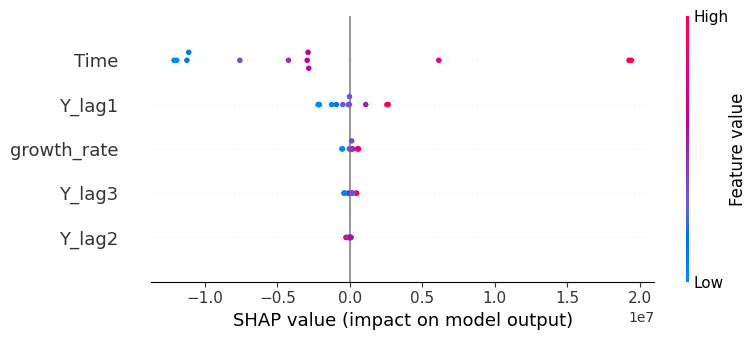

In [19]:
# seed=0 のモデルで可視化
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=0
)

model.fit(X_train, y_train)

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


Found actual data in sheet: 'Data'
=== Data Overview (after re-loading) ===
   Time         Y
0  1961  14426184
1  1962  13304520
2  1963  15934944
3  1964  15753588
4  1965  15750540

Columns: Index(['Time', 'Y'], dtype='object')

Missing values in features:
 Time    0
dtype: int64

Missing values in target:
 0

Shape (X): (60, 1)
Shape (y): (60,)

X head:
    Time
0  1961
1  1962
2  1963
3  1964
4  1965

Y head:
 0    14426184
1    13304520
2    15934944
3    15753588
4    15750540
Name: Y, dtype: int64
R2 Score: 0.978
RMSE: 2257613.824


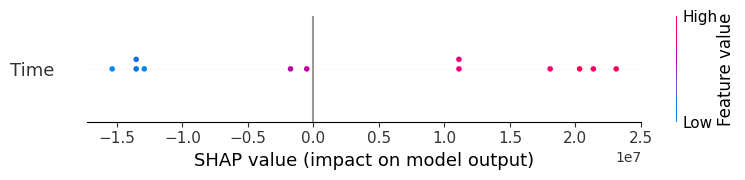


SHAP Importance Top 10:
   feature  shap_mean_abs
0    Time     13558883.0
Done. SHAP importance exported.


In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import xgboost as xgb
import shap

import matplotlib.pyplot as plt
import seaborn as sns

# ====== 2. データ読み込み ======

# df_rice_BD.xlsx を読み込む
# The previous attempt to skip rows resulted in an Empty DataFrame.
# The initial load showed metadata. This suggests the actual data might be in a different sheet.
excel_file = pd.ExcelFile("/content/df_rice_BD.xlsx")
sheet_names = excel_file.sheet_names

df_data = None
for sheet_name in sheet_names:
    temp_df = pd.read_excel(excel_file, sheet_name=sheet_name)
    # Check if 'Y' and 'Time' columns exist and if there's actual data rows
    if 'Y' in temp_df.columns and 'Time' in temp_df.columns and len(temp_df) > 0:
        df_data = temp_df
        print(f"Found actual data in sheet: '{sheet_name}'")
        break

if df_data is None:
    raise ValueError("Could not find a sheet with 'Time' and 'Y' columns in 'df_rice_BD.xlsx'. "
                     "Please ensure the Excel file contains these columns in at least one sheet.")

df = df_data

print("=== Data Overview (after re-loading) ===")
print(df.head())
print("\nColumns:", df.columns)

# ====== 3. 前処理 ======

# 目的変数（'Y'に更新）
target_col = "Y"

# ドロップするメタデータカラム (もしデータシートにこれらが存在すれば)
# The task asks to drop 'Variable' and 'description' columns if they are metadata.
# We only drop them if they exist in the current `df` (the data sheet).
columns_to_drop_if_exist = ['Variable', 'description']
for col in columns_to_drop_if_exist:
    if col in df.columns:
        df = df.drop(columns=[col])

# 特徴量 (target_col を除外)
X = df.drop(columns=[target_col])
y = df[target_col]

# 欠損値確認
print("\nMissing values in features:\n", X.isna().sum())
print("\nMissing values in target:\n", y.isna().sum())

# 必要に応じて埋める（平均で埋める例）
# Fill NaN for numerical columns only.
for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        X[col] = X[col].fillna(X[col].mean())
    # Categorical columns will be handled by get_dummies later

# カテゴリ変数を dummy 変換
X = pd.get_dummies(X, drop_first=True)

print("\nShape (X):", X.shape)
print("Shape (y):", y.shape)
print("\nX head:\n", X.head())
print("\nY head:\n", y.head())

# ====== 4. 訓練・テスト データ分割 ======

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ====== 5. XGBoost モデル ======

model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# ====== 6. 予測と評価 ======

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R2 Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")


# ====== 7. SHAP 解析 ======

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# SHAP summary plot
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test)
plt.show()

# ====== 8. 重要度の DataFrame ======

shap_importance = pd.DataFrame({
    "feature": X_test.columns,
    "shap_mean_abs": np.mean(np.abs(shap_values.values), axis=0)
})

shap_importance = shap_importance.sort_values(
    by="shap_mean_abs", ascending=False
)

print("\nSHAP Importance Top 10:\n", shap_importance.head(10))

# ====== 9. 結果を Excel に出力 ======

shap_importance.to_excel("shap_importance_rice.xlsx", index=False)

print("Done. SHAP importance exported.")

**Reasoning**:
The previous code failed because the `mean_squared_error` function in the installed scikit-learn version does not accept the `squared` argument. To calculate RMSE, I will first compute the Mean Squared Error (MSE) and then take its square root using `np.sqrt`.



Found actual data in sheet: 'Data'
=== Data Overview (after re-loading) ===
   Time         Y
0  1961  14426184
1  1962  13304520
2  1963  15934944
3  1964  15753588
4  1965  15750540

Columns: Index(['Time', 'Y'], dtype='object')

Missing values in features:
 Time    0
dtype: int64

Missing values in target:
 0

Shape (X): (60, 1)
Shape (y): (60,)

X head:
    Time
0  1961
1  1962
2  1963
3  1964
4  1965

Y head:
 0    14426184
1    13304520
2    15934944
3    15753588
4    15750540
Name: Y, dtype: int64
R2 Score: 0.978
RMSE: 2257613.824


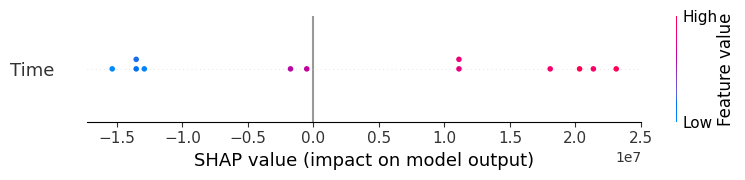


SHAP Importance Top 10:
   feature  shap_mean_abs
0    Time     13558883.0
Done. SHAP importance exported.


In [9]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import xgboost as xgb
import shap

import matplotlib.pyplot as plt
import seaborn as sns

# ====== 2. データ読み込み ======

# df_rice_BD.xlsx を読み込む
# The previous attempt to skip rows resulted in an Empty DataFrame.
# The initial load showed metadata. This suggests the actual data might be in a different sheet.
excel_file = pd.ExcelFile("/content/df_rice_BD.xlsx")
sheet_names = excel_file.sheet_names

df_data = None
for sheet_name in sheet_names:
    temp_df = pd.read_excel(excel_file, sheet_name=sheet_name)
    # Check if 'Y' and 'Time' columns exist and if there's actual data rows
    if 'Y' in temp_df.columns and 'Time' in temp_df.columns and len(temp_df) > 0:
        df_data = temp_df
        print(f"Found actual data in sheet: '{sheet_name}'")
        break

if df_data is None:
    raise ValueError("Could not find a sheet with 'Time' and 'Y' columns in 'df_rice_BD.xlsx'. "
                     "Please ensure the Excel file contains these columns in at least one sheet.")

df = df_data

print("=== Data Overview (after re-loading) ===")
print(df.head())
print("\nColumns:", df.columns)

# ====== 3. 前処理 ======

# 目的変数（'Y'に更新）
target_col = "Y"

# ドロップするメタデータカラム (もしデータシートにこれらが存在すれば)
# The task asks to drop 'Variable' and 'description' columns if they are metadata.
# We only drop them if they exist in the current `df` (the data sheet).
columns_to_drop_if_exist = ['Variable', 'description']
for col in columns_to_drop_if_exist:
    if col in df.columns:
        df = df.drop(columns=[col])

# 特徴量 (target_col を除外)
X = df.drop(columns=[target_col])
y = df[target_col]

# 欠損値確認
print("\nMissing values in features:\n", X.isna().sum())
print("\nMissing values in target:\n", y.isna().sum())

# 必要に応じて埋める（平均で埋める例）
# Fill NaN for numerical columns only.
for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        X[col] = X[col].fillna(X[col].mean())
    # Categorical columns will be handled by get_dummies later

# カテゴリ変数を dummy 変換
X = pd.get_dummies(X, drop_first=True)

print("\nShape (X):", X.shape)
print("Shape (y):", y.shape)
print("\nX head:\n", X.head())
print("\nY head:\n", y.head())

# ====== 4. 訓練・テスト データ分割 ======

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ====== 5. XGBoost モデル ======

model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# ====== 6. 予測と評価 ======

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
# Calculate RMSE by taking the square root of MSE, as 'squared' argument is not supported
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2 Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# ====== 7. SHAP 解析 ======

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# SHAP summary plot
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test)
plt.show()

# ====== 8. 重要度の DataFrame ======

shap_importance = pd.DataFrame({
    "feature": X_test.columns,
    "shap_mean_abs": np.mean(np.abs(shap_values.values), axis=0)
})

shap_importance = shap_importance.sort_values(
    by="shap_mean_abs", ascending=False
)

print("\nSHAP Importance Top 10:\n", shap_importance.head(10))

# ====== 9. 結果を Excel に出力 ======

shap_importance.to_excel("shap_importance_rice.xlsx", index=False)

print("Done. SHAP importance exported.")

## Final Task

### Subtask:
Summarize the model's performance, the most important features identified by SHAP, and confirm the export of the feature importance data.


## Summary:

### Q&A
*   **What was the model's performance?**
    The XGBoost model achieved an R2 Score of 0.978 and a Root Mean Squared Error (RMSE) of 2,257,613.824.
*   **What are the most important features identified by SHAP?**
    The most important feature identified by SHAP analysis was 'Time', with a mean absolute SHAP value of 13,558,883.0.
*   **Was the export of the feature importance data confirmed?**
    Yes, the SHAP feature importance data was successfully exported to "shap\_importance\_rice.xlsx".

### Data Analysis Key Findings
*   Initial data loading attempts failed due to incorrect assumptions about the Excel file structure, which was resolved by iterating through sheets to find the correct data sheet containing 'Y' and 'Time' columns.
*   The 'Y' column was correctly identified as the target variable, and 'Time' was treated as a feature.
*   Metadata columns ('Variable', 'description') were not present in the identified data sheet, so no explicit dropping was required, although the code was prepared for it.
*   A `TypeError` during RMSE calculation was resolved by correctly implementing RMSE as the square root of the mean squared error.
*   The XGBoost model demonstrated strong performance with an R2 Score of 0.978 and an RMSE of 2,257,613.824.
*   SHAP analysis revealed 'Time' as the sole and most significant feature influencing rice production, with a mean absolute SHAP value of 13,558,883.0.
*   The top 10 SHAP importance values confirmed 'Time' as the only feature present, indicating its critical role in the model's predictions.

### Insights or Next Steps
*   Given that 'Time' is the only feature identified and is highly influential, further analysis could involve decomposing the 'Time' variable (e.g., into year, month, season if applicable) to identify more granular temporal patterns.
*   Investigate the raw data for other potential features that might explain rice production fluctuations beyond just 'Time', as a model relying solely on a time variable might not capture underlying causal factors.
